In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

Introduce all necessary functions:
    - reading the SDSS-CRTS cross-matched catalogue 
    - make cuts in the available objecs according to selection criteria 

In [2]:
def get_qso_catalog(catalog):
    if catalog == 's82drw':
        File = 'CRTS_SDSS_cross_matched_qso_s82drw_catalog.txt'
    if catalog == 'DB_QSO':
        File = 'CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt'
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File, dtype=str)
    qso_catalog = {}
    print 'Zipping CRTS-SDSS quasars catalog from ', File, ' ...'
    for label, column in zip(colnames, datatable.T):
        qso_catalog[label] = column
    
    qso_names = np.genfromtxt('CRTS_SDSS_cross_matched_qso_names.txt', dtype=str)    
    for i in range(len(qso_names)):
        qso_names[i] = qso_names[i][4:-4]
    print 'Read in ', len(qso_catalog['redshift']), ', quasars from CRTS'
    return  colnames, qso_catalog, qso_names
    
def get_stars_catalog():
    File = 'CRTS_SDSS_cross_matched_stars_catalog.txt'
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File)
    stars_catalog = {}
    print 'zipping CRTS-SDSS stars catalog...'
    for label, column in zip(colnames, datatable.T):
        stars_catalog[label] = column
        
    return  colnames, stars_catalog

cols1, qso_cat, qso_names = get_qso_catalog(catalog='DB_QSO') 
cols2 , star_cat= get_stars_catalog()

# Perform cuts 
def cut_qso(qso_cat=qso_cat, qso_names=qso_names, mMin=-9, mMax=19, 
            mErrMin = -9, mErrMax = 0.3,cut_mag='r', report_mag = 'r'):

    mask_mag = (qso_cat[cut_mag].astype(float) > mMin) * (qso_cat[cut_mag].astype(float) < mMax) 
    mask_err = (qso_cat['CRTS_avg_e'].astype(float) > mErrMin) * (qso_cat['CRTS_avg_e'].astype(float) < mErrMax)
    mask = mask_mag * mask_err 
    qso_id = qso_names[mask]
    qso_mags = qso_cat[report_mag][mask]
    print '\n These cuts reduced the number of qso  in the sample from', \
          len(qso_cat['redshift']), ' to ', len(qso_id)
    return  qso_id

def cut_stars(star_cat=star_cat, mMin=-9, mMax=19, mErrMin = -9, 
              mErrMax = 0.3, gi_Min = -1, gi_Max=1 , cut_mag='r_mMed',
              report_mag = 'r_mMed'):

    mask_mag = (star_cat[cut_mag] > mMin) * (star_cat[cut_mag] < mMax) 
    mask_err = (star_cat['CRTS_Merr'] > mErrMin) * (star_cat['CRTS_Merr'] < mErrMax)
    SDSS_gi = star_cat['g_mMed'] - star_cat['i_mMed']
    mask_color = (SDSS_gi > gi_Min ) * (SDSS_gi < gi_Max)
    mask = mask_mag * mask_err * mask_color
    star_id_f = star_cat['crts_id'][mask]
    star_mags = star_cat[report_mag][mask]
    # convert floats to strings without comma and zeros
    star_id = np.array(["{:.0f}".format(name) for name in star_id_f])
    print '\n These cuts reduced the number of stars  in the sample from', \
          len(star_cat['CRTS_M']), ' to ', len(star_id)
    return  star_id


Zipping CRTS-SDSS quasars catalog from  CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt  ...
Read in  7601 , quasars from CRTS
zipping CRTS-SDSS stars catalog...


Introduce xi, ei reading functions

## 1) Use SDSS g-mag, read 18-18.5 files only 

In [41]:
Min = 17
Max = 18
magnitudes = ['g','r']

objects_in_cut = {}

for mag in magnitudes : 
    cut_mag = mag
    report_mag = mag
    
    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))
    print('\n Reporting SDSS %s  '% report_mag)

    good_ids_S_blue = cut_stars(mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                              gi_Max=1, cut_mag=cut_mag + '_mMed', 
                                              report_mag=report_mag + '_mMed')
    
    good_ids_S_red = cut_stars(mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = 1, 
                                           gi_Max=3, cut_mag=cut_mag + '_mMed', 
                                           report_mag=report_mag + '_mMed')
    
    good_ids_QSO = cut_qso(mMin = Min, mMax=Max, mErrMax = 0.3, 
                                               cut_mag=cut_mag,report_mag=report_mag)
    objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'starsR':good_ids_S_red, 
                           'qso':good_ids_QSO}
    


Using now only lightcurves with SDSS  17.000000< g < 18.000000

 Reporting SDSS g  

 These cuts reduced the number of stars  in the sample from 47787  to  2628

 These cuts reduced the number of stars  in the sample from 47787  to  1528

 These cuts reduced the number of qso  in the sample from 7601  to  127

Using now only lightcurves with SDSS  17.000000< r < 18.000000

 Reporting SDSS r  

 These cuts reduced the number of stars  in the sample from 47787  to  2795

 These cuts reduced the number of stars  in the sample from 47787  to  2993

 These cuts reduced the number of qso  in the sample from 7601  to  185


## 2) Check what's the overlap : Venn diagrams 

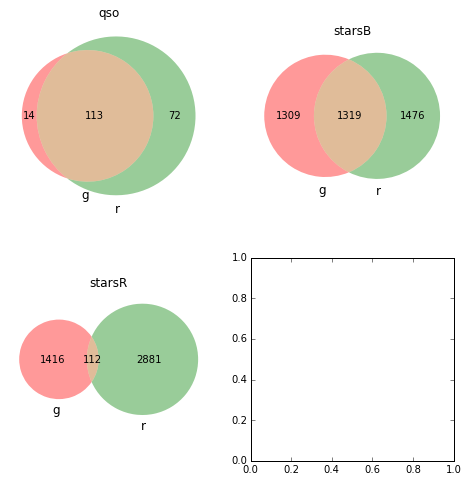

In [42]:
%matplotlib inline
# This shows the number of objects in each category 
f, ax = plt.subplots(2,2, figsize=(8,8))
a = ax.ravel()
objects = objects_in_cut['g'].keys()
for i in range(len(objects)):
    a[i].set_title(objects[i])
    venn2([set(objects_in_cut['g'][objects[i]]),
           set(objects_in_cut['r'][objects[i]])], 
          ('g', 'r'), ax=a[i] )


## 3) Make g, r, gr bins, and merged versions


In [43]:
bins = {}
#bin_types = ['g','r','gr', 'r_cut', 'g_cut']
bin_types = ['r_cut', 'g_cut']
objects = objects_in_cut['g'].keys()

# first need to explicitly initialize the dictionaries 
for b in bin_types:
    bins[b] = {}
    
for obj in objects : 
    #bins['g'][obj] = np.setdiff1d(objects_in_cut['g'][obj], objects_in_cut['r'][obj])
    #bins['r'][obj] =  np.setdiff1d(objects_in_cut['r'][obj], objects_in_cut['g'][obj])
    #bins['gr'][obj] =  np.intersect1d(objects_in_cut['g'][obj], objects_in_cut['r'][obj])
    bins['r_cut'][obj] = objects_in_cut['r'][obj]
    bins['g_cut'][obj] = objects_in_cut['g'][obj]


In [139]:
# Show that all the numbers agree with Venn diagrams above 
#for b in bin_types:
#    print '\n For bin', b
#    for obj in objects :
#        print obj, len(bins[b][obj])

## 4) Read in xi, ei for objects in bins, selecting log(tau) < 1.7 

In [44]:
# inside the main loop : get tau, delflx from a master file, either qso or star
def add_tau_delflx(File, inDir, data, fc):
    # read in storage arrays
    delflx = data[0]  
    tau = data[1]
    err = data[2]
    master_acc_list = data[3]   
    
    # grab the object name 
    master_name = File[3:-4]
    
    # read in the i-th master file 
    master =  np.genfromtxt(inDir+File, dtype=str)
    
    # read in tau,  del_mag,  del_mag_err for quasars on the list 
    delflx = np.append(delflx, master[:,0].astype(float))
    tau = np.append(tau, master[:,1].astype(float))
    
    if fc is not None :  # correct new master rows only if  asked for 
        err = np.append(err, master[:,2].astype(float)*fc)
    else:                # otherwise read in without any correction
        err = np.append(err, master[:,2].astype(float))
    master_names  = np.append(master_acc_list, np.array(len(master[:,0])*[master_name]))
    
    return delflx, tau, err, master_names
    
def read_xi_ei(inDirStars, good_ids_S_blue, good_ids_S_red, inDirQSO,
                 good_ids_QSO, xi_ei_data=None, fc=None):
                     
    inDir_S       = inDirStars
    good_ids_S_blue    = good_ids_S_blue
    good_ids_S_red    = good_ids_S_red
    inDir_Q       = inDirQSO
      
    
    # Read the Stellar Master file names 
    masterFiles_S = os.listdir(inDir_S)
    masterFilesS1 = [name[3:-4] for name in masterFiles_S]
    
    good_masterSB = np.array(masterFiles_S)[np.in1d(masterFilesS1, good_ids_S_blue)]
    good_masterSR = np.array(masterFiles_S)[np.in1d(masterFilesS1, good_ids_S_red)]
    
    # Read the QSO Master file names 
    masterFiles_Q = os.listdir(inDir_Q)
    masterFilesQ1 = [name[3:-4] for name in masterFiles_Q]
    good_masterQ = np.array(masterFiles_Q)[np.in1d(masterFilesQ1, good_ids_QSO)]
    

  
    # If no previous read-in xi, ei exists, initialize arrays    
    if xi_ei_data is None : 
        print 'making new delflx, tau, xi arrays'
        delflx_S      = np.empty(0,dtype=float)
        tau_S         = np.empty(0,dtype=float)
        err_S         = np.empty(0,dtype=float)
        master_acc_list_S = np.empty(0, dtype=str)
    
        
       
        delflx_Q      = np.empty(0,dtype=float)
        tau_Q         = np.empty(0,dtype=float)
        err_Q         = np.empty(0,dtype=float)
        master_acc_list_Q = np.empty(0, dtype=str)
        
        # Initialize the data structures to which more and more delta_t and delta_mag
        # are addded from each consecutive master file 
        qso_data = [delflx_Q, tau_Q, err_Q, master_acc_list_Q] 
        star_data_blue = [delflx_S, tau_S, err_S, master_acc_list_S]
        star_data_red  = [delflx_S, tau_S, err_S, master_acc_list_S]
        
    else:
        print 'using existing xi ei arrays'
        qso_data = xi_ei_data[0]
        star_data_blue = xi_ei_data[1]
        star_data_red = xi_ei_data[2]
        
    print('\n')
    c = 0
    for File in good_masterQ: #  len(masterFiles_Q)
        #print 'Reading in ', File
        
        qso_data = add_tau_delflx(File,inDir_Q, qso_data, fc)
        c += 1 
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterQ))
            print('\r----- Already read %d%% of qso'%pers),
    
    print('\n')
    c = 0                   
    for File in good_masterSB:    # [:len(good_masterQ)]
        #print 'Reading in ', File
        star_data_blue = add_tau_delflx(File, inDir_S,star_data_blue, fc)
        c += 1 
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterSB))
            print('\r----- Already read %d%% of Blue Stars'%pers),  
    print('\n')
    c = 0                         
    for File in good_masterSR:   # [:len(good_masterQ)]
        #print 'Reading in ', File
        star_data_red = add_tau_delflx(File, inDir_S, star_data_red, fc)      
        c += 1               
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterSR))
            print('\r----- Already read %d%% of Red Stars'%pers),          
                     
    print('returning xi, ei for ... %d objects'%len(good_masterQ))
                            
    return  qso_data, star_data_blue, star_data_red

In [45]:
inDirStars   = 'sf_file_per_LC/star/'
inDirQSO = 'sf_file_per_LC/qso/'

out_dic = {}

for b in bins.keys():
    print '\nReading in  xi, ei  for bin ', b
    out_dic[b] = {}   # initialize the dic 
    
    good_ids_S_blue = bins[b]['starsB']
    good_ids_S_red = bins[b]['starsR']
    good_ids_QSO = bins[b]['qso']
    
    qso, starB, starR = read_xi_ei(inDirStars, good_ids_S_blue, good_ids_S_red, inDirQSO,
                  good_ids_QSO,xi_ei_data=None, fc=None)

    # put into a dictionary : makes it more explicit 
    out_dic[b] = {'starsB': starB, 'starsR': starR, 'qso':qso}
    


Reading in  xi, ei  for bin  r_cut
making new delflx, tau, xi arrays


----- Already read 100% of qso 

----- Already read 100% of Blue Stars 

----- Already read 99% of Red Stars returning xi, ei for ... 185 objects

Reading in  xi, ei  for bin  g_cut
making new delflx, tau, xi arrays


----- Already read 98% of qso 

----- Already read 99% of Blue Stars 

----- Already read 99% of Red Stars returning xi, ei for ... 127 objects


In [121]:
# For some objects some bins are empty: I hope this does not throw an exception in read_xi_ei.
# Otherwise need to modify the code to allow for that 

#for key in bins.keys():
#    for obj in bins['g'].keys() :
#        print len(bins[key][obj])


In [46]:
# Select   log(tau) < 1.7 from each set of xi,ei  

out_dic_cut = {}

for b in out_dic.keys():
    out_dic_cut[b] = {}
    
    for obj in out_dic[b].keys() : 
        
        print '\n Selecting sample log(tau) < 1.7 for bin', b, ' for ', obj
        
        xi  = out_dic[b][obj][0]
        tau = out_dic[b][obj][1]
        ei  = out_dic[b][obj][2]
        n   = out_dic[b][obj][3]
        
        # make log(tau) cut
        print('Before log(tau) cut we have %d objects'% len(np.unique(n)))
        
        mask_tau = np.log10(tau)<1.7
        
        print('After log(tau) cut we have %d objects'% len(np.unique(n[mask_tau])))
        
        # save xi,ei,tau, n  that satisfy the cut 
        out_dic_cut[b][obj] = [xi, tau, ei, n]
        


 Selecting sample log(tau) < 1.7 for bin r_cut  for  qso
Before log(tau) cut we have 185 objects
After log(tau) cut we have 185 objects

 Selecting sample log(tau) < 1.7 for bin r_cut  for  starsB
Before log(tau) cut we have 2795 objects
After log(tau) cut we have 2795 objects

 Selecting sample log(tau) < 1.7 for bin r_cut  for  starsR
Before log(tau) cut we have 2993 objects
After log(tau) cut we have 2993 objects

 Selecting sample log(tau) < 1.7 for bin g_cut  for  qso
Before log(tau) cut we have 127 objects
After log(tau) cut we have 127 objects

 Selecting sample log(tau) < 1.7 for bin g_cut  for  starsB
Before log(tau) cut we have 2628 objects
After log(tau) cut we have 2628 objects

 Selecting sample log(tau) < 1.7 for bin g_cut  for  starsR
Before log(tau) cut we have 1528 objects
After log(tau) cut we have 1528 objects


## 5) Calculate descriptive statistics per bin  per sample

In [ ]:
## Statistics to calculate : 
## median CRTS mag,  median CRTS avg err ,  median CRTS ei error

In [47]:
# Figure out what objects are in the log(tau) < 1.7 samples : make new lists of names, 
# similar to making bins in the first place 

# Now grab unique names of objects that appear in my samples
new_bins = {}
for b in out_dic_cut.keys():
    new_bins[b] = {}
    print '\n b=', b
    for obj in out_dic_cut[b].keys():
        print 'obj=', obj
        uniq_names = np.unique(out_dic_cut[b][obj][3]) 
        new_bins[b][obj] = uniq_names
        print len(uniq_names)
        
    


 b= r_cut
obj= qso
185
obj= starsB
2795
obj= starsR
2993

 b= g_cut
obj= qso
127
obj= starsB
2628
obj= starsR
1528


In [29]:
# Grab mean lightcurve magnitude from CRTS for each object in the sample : 
#qso_cat.keys()  'CRTS_avg_m'
#star_cat.keys() 'CRTS_M'

# Grab also mean lightcurve error from CRTS for each object in the sample :
#qso_cat.keys()  'CRTS_avg_e'
#star_cat.keys() 'CRTS_Merr'


In [35]:
#np.sum(np.in1d(new_bins['g']['starsB'], new_bins['g']['starsR']))

0

In [48]:
# Grab lightcurve - averaged properties , averaged over all objects 
# of a given type in my sample 

new_bins_props = {}
new_bins_arrays = {}

for b in new_bins.keys():
    print '\nb=', b
    new_bins_props[b] = {}
    new_bins_arrays[b] = {}
    
    for obj in new_bins[b].keys():
        print 'obj=', obj
        if obj == 'qso' : 
            CRTS_avg_err = [qso_cat['CRTS_avg_e'][qso_cat['CRTS_id']==qso][0] for qso
                           in new_bins[b][obj]]
            CRTS_avg_mag = [qso_cat['CRTS_avg_m'][qso_cat['CRTS_id']==qso][0] for qso
                           in new_bins[b][obj]]
            
        else : 
            
            CRTS_avg_err = [star_cat['CRTS_Merr'][star_cat['crts_id']== float(star)][0] for star
                           in new_bins[b][obj]]
            CRTS_avg_mag = [star_cat['CRTS_M'][star_cat['crts_id']==float(star)][0] for star
                           in new_bins[b][obj]]
        
        # change into floats and arrays 
        arr1 = np.array(CRTS_avg_err).astype(float)
        arr2 = np.array(CRTS_avg_mag).astype(float)
        new_bins_arrays[b][obj] = {'CRTS_avg_err' : arr1,
                                   'CRTS_avg_mag' : arr2}
        
        med_avg_err = np.median(arr1)
        med_avg_mag = np.median(arr2) 
        
        new_bins_props[b][obj] = {'median_CRTS_avg_err':med_avg_err, 
                                 'median_CRTS_avg_mag':med_avg_mag
                                }


b= r_cut
obj= qso
obj= starsB
obj= starsR

b= g_cut
obj= qso
obj= starsB
obj= starsR


In [49]:
# Grab magnitude difference quantities, corresponding to individual delta_mag,  
# delta_mag_err, delta_tau  points in my sample 

for b in new_bins.keys():
    print '\n', b
    for obj in new_bins[b].keys():
        
        # Grab  delta_magnitude and corresponding errors from lightcurve points 
        # added in quadrature 
        ei = out_dic_cut[b][obj][2]
        mi = out_dic_cut[b][obj][0]
        
        # Calculate median  ei  for each bin
        new_bins_props[b][obj]['median_CRTS_ei'] =  np.median(ei)
        
        # Calculate robust standard deviation for delta mag 
        if len(mi) > 0 : 
            
            new_bins_props[b][obj]['stdev_robust_mi'] = 0.7414 *(np.percentile(mi,75) - np.percentile(mi,25))
        else : 
            new_bins_props[b][obj]['stdev_robust_mi'] = np.nan
            
        # Calculate robust standard deviation for chi_ij = (delta_mag_ij / error_ij)
        if len(mi) > 0 and len(ei) > 0 : 
            chi = mi / ei 
            new_bins_props[b][obj]['stdev_robust_chi'] = 0.7414 *(np.percentile(chi,75) - np.percentile(chi,25))
        else : 
            new_bins_props[b][obj]['stdev_robust_chi'] = np.nan


r_cut

g_cut


In [108]:
#for b in new_bins_props.keys():
#    print '\nbin', b 
#    for obj in new_bins_props[b].keys():
#        print '\n', obj 
#        print new_bins_props[b][obj]

## 6) Save all results to a file, and print them to the screen 

In [25]:
temp_head

'{0:8s}|{1:8}|{2:8}|{3:8}'

In [50]:
# save to a file 
pre = ''
for b in bin_types:
    pre += b
    
savefile = 'CRTS_'+str(Min)+'-'+str(Max)+'_mag_'+pre+'.txt'
f = open(savefile,"w")

# loop over all lines to display
for prop in new_bins_props[b][obj].keys():

    data = [[],[],[]]

    i = 0
    for obj in new_bins_props[b].keys():
        data[i].append(obj)
        for b in new_bins_props.keys():
            data[i].append(new_bins_props[b][obj][prop])
        i += 1

    # assume that your data rows are tuples
    temp_head = "{0:8s}|{1:8}|{2:8}" # column widths: 8, 10, 15, 7, 10
    temp_lines = "{0:8s}|{1:8.3f}|{2:8.3f}"
    
    
    
    s_title = '        ' +  prop
    print s_title
    f.write(s_title+'\n')
    
    s_sep = '    '
    print s_sep
    f.write(s_sep+'\n')

    s_head = temp_head.format(" ", "r_cut", "g_cut")
    print  s_head
    f.write(s_head+'\n')
    
    for rec in data: 
        s_line  = temp_lines.format(*rec)
        print s_line
        f.write(s_line+'\n')
    print '    '
    f.write('   '+'\n')

# At the end, close the file 
f.close()
print 'Saved all to a file', savefile  

        median_CRTS_ei
    
        |r_cut   |g_cut   
qso     |   0.143|   0.139
starsB  |   0.070|   0.060
starsR  |   0.067|   0.053
    
        stdev_robust_mi
    
        |r_cut   |g_cut   
qso     |   0.305|   0.305
starsB  |   0.063|   0.047
starsR  |   0.058|   0.035
    
        median_CRTS_avg_mag
    
        |r_cut   |g_cut   
qso     |  17.578|  17.392
starsB  |  17.436|  16.944
starsR  |  17.356|  16.386
    
        stdev_robust_chi
    
        |r_cut   |g_cut   
qso     |   1.991|   2.027
starsB  |   0.909|   0.775
starsR  |   0.870|   0.671
    
        median_CRTS_avg_err
    
        |r_cut   |g_cut   
qso     |   0.050|   0.048
starsB  |   0.050|   0.043
starsR  |   0.048|   0.037
    
Saved all to a file CRTS_17-18_mag_r_cutg_cut.txt


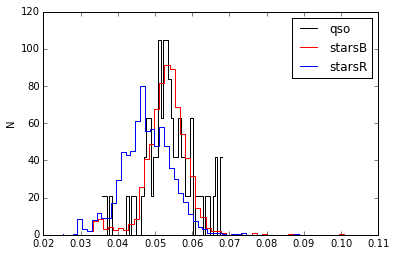

In [135]:
%matplotlib inline 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
nbins = 50
colors = ['black','red','blue']
for i in range(len(new_bins_arrays['r'].keys())):
    obj = new_bins_arrays['r'].keys()[i]
    hist1, bin_edges = np.histogram(new_bins_arrays['r'][obj]['CRTS_avg_err'], bins=nbins, density=True)
    bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2
    ax.plot(bin_centres1, hist1, color = colors[i], ls = 'steps', label=obj)

ax.legend()
plt.savefig(str(Min)+'-'+str(Max)+'_test_r_bin-CRTS_avg_err_.png')
